In [1]:
"""
Tutorial to demonstrate running parameter estimation on a reduced parameter
space for an injected signal.

This example estimates the masses using a uniform prior in both component masses
and distance using a uniform in comoving volume prior on luminosity distance
between luminosity distances of 100Mpc and 5Gpc, the cosmology is Planck15.
"""

import bilby
import numpy as np

import matplotlib.pyplot as plt
import config

config.conf_matplolib()

# NR data

In [2]:
Msun = 2 * 1e30
G = 6.6743 * 1e-11
c = 2.99792458 * 1e8
Mevent = 62

Tc = G * Msun * Mevent / (c**3)

merger_time = 0  # 1126259642.413

In [5]:
nr_data = np.genfromtxt("prepared_waveform_fseries2.txt")

In [6]:
nr_data.shape

(2023, 3)

In [16]:
# Simulation name
sim_name = "SXS:BBH:0001"

# Parameters
M = 40
D = 1000
inc = 0
coa_phase = 0
sampling_frequency = 2048
delta_t = 1.0 / sampling_frequency
q = 1

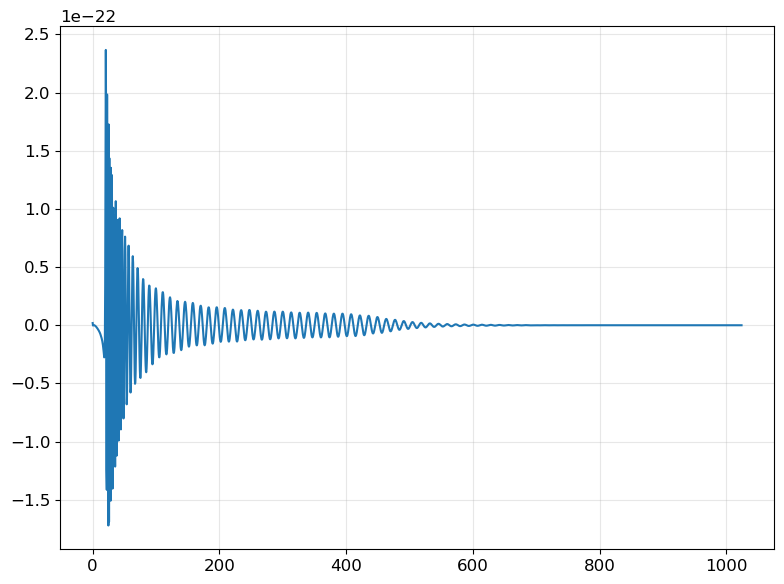

In [17]:
hp0 = nr_data[:, 1]
hc0 = nr_data[:, 2]

maxloc = np.argmax(hp0**2 + hc0**2)

ht0 = nr_data[:, 0]
# ht0 -= ht0[maxloc]
# ht0 += merger_time

plt.plot(ht0, hp0)
plt.show()

In [18]:
def nr_injection(time):
    """
    This function produces the amplitude for a given
    NR-derived signal at any given time for a given data file.

    Parameters
    ----------
    time : array-like
        A time, or an array of times, at which the amplitudes should be returned.
    datafile : str
        The path to the data file containing the injection.
    """

    local_time_axis = ht0

    hp = np.interp(time, local_time_axis, hp0).real
    hx = np.interp(time, local_time_axis, hc0).real

    # print(hp, hx)
    return {"plus": hp, "cross": hx}

In [19]:
# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = f"fast_tutorial_nr_{sim_name}_inj8_dell"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
bilby.core.utils.random.seed(88170235)

In [20]:
Mtotal = 40
mass1 = Mtotal * q / (1 + q)
mass2 = Mtotal / (1 + q)
# merger_time = 1126259642.413


# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
analysis_duration = 1.97412109375  # Mtotal*len(ht0)/sampling_frequency
# sampling_frequency = 2048.0
minimum_frequency = 20

print("Analysis duration is ", analysis_duration)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=mass1,
    mass_2=mass2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0,
    phi_jl=0,
    #    spin_1x=0,
    #    spin_1y=0,
    #    spin_1z=0,
    #    spin_2x=0,
    #    spin_2y=0,
    #    spin_2z=0,
    luminosity_distance=1000.0,
    geocent_time=merger_time,
    theta_jn=inc,
    psi=0,
    phase=coa_phase,
    ra=1.375,
    dec=-1.2108,
)

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=analysis_duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

23:22 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Analysis duration is  1.97412109375


In [21]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=analysis_duration,
    start_time=merger_time - 4,
)

new_time = np.linspace(ht0[0], ht0[-1], 4097)

inj_pol_dict = nr_injection(new_time)

print(inj_pol_dict["plus"].shape)

# Create a different waveform generator for injection
ifos.inject_signal(
    injection_polarizations=inj_pol_dict, parameters=injection_parameters
)

23:22 bilby WARNING : Injecting signal outside segment, start_time=-4, merger time=0.


(4097,)


ValueError: operands could not be broadcast together with shapes (4097,) (2023,) 

In [13]:
print(inj_pol_dict["plus"].shape)

(4097,)


In [12]:
# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "luminosity_distance",
    "theta_jn",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(analysis_duration, minimum_frequency)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)

14:40 bilby INFO    : No prior given, using default BBH priors in /home/vaishakprasad/anaconda3/envs/gw2/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [13]:
injection_parameters["geocent_time"]

0

In [14]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=1000,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

14:40 bilby INFO    : Running for label 'fast_tutorial_nr_SXS:BBH:0001_inj8_dell', output will be saved to 'outdir'
14:40 bilby INFO    : Using lal version 7.5.0
14:40 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.5.0;Id: edd3f4e61431c1a0c6a7be13c0be9644be1f6745;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:40 bilby INFO    : Using lalsimulation version 5.4.0
14:40 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.4.0;Id: 57c31779c344c6abf3c1d294bab00dd58ed17875;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:40 bilby INFO    : Analysis priors:
14:40 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
14:40 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathc

1697it [00:35, 48.03it/s, bound:16 nc: 66 ncall:2.5e+04 eff:6.8% logz-ratio=-181.37+/-0.08 dlogz:458.012>0.1]  

14:40 bilby INFO    : Run interrupted by signal 2: checkpoint and exit on 130


14:40 bilby INFO    : Written checkpoint file outdir/fast_tutorial_nr_SXS:BBH:0001_inj8_dell_resume.pickle


Exception while calling loglikelihood function:
  params: [ 0.73105561 48.1208062 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/vaishakprasad/anaconda3/envs/gw2/lib/python3.11/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vaishakprasad/anaconda3/envs/gw2/lib/python3.11/site-packages/bilby/core/sampler/dynesty.py", line 53, in _log_likelihood_wrapper
    return _sampling_convenience_dump.likelihood.log_likelihood_ratio()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vaishakprasad/anaconda3/envs/gw2/lib/python3.11/site-packages/bilby/gw/likelihood/base.py", line 406, in log_likelihood_ratio
    per_detector_snr = self.calculate_snrs(
                       ^^^^^^^^^^^^^^^^^^^^
  File "/home/vaishakprasad/anaconda3/envs/gw2/lib/python3.11/site-packages/bilby/gw/likelihood/base.py", line 270, in calculate_snrs
    d_inner_h = interferometer.inner_product(signal=sign

SystemExit: 130

/home/vaishakprasad/anaconda3/envs/gw2/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


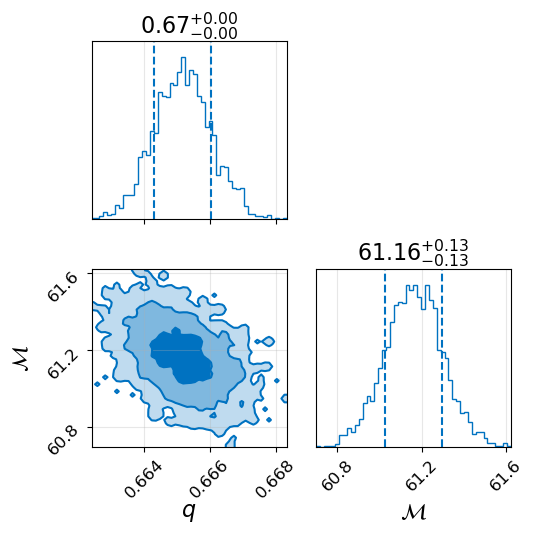

In [ ]:
# Make a corner plot.
result.plot_corner()